# Dataset

In [faces.zip](https://myslu.stlawu.edu/~ltorrey/ml/faces.zip) you will find a collection of face images.

Download and explore this collection.

*   What are the classes? How many of each are there?
*   What shape are the images (width, height, color channels)?
*   What classification accuracy would you expect from random guessing?

In [ ]:
import pandas as pd
import seaborn as sns
from tensorflow import keras

In [ ]:
!wget  https://myslu.stlawu.edu/~ltorrey/ml/faces.zip
!unzip -q faces.zip

In [ ]:
from PIL import Image
image_path = '/content/faces/test/angry/PrivateTest_11296953.jpg'
image = Image.open(image_path)
width, height = image.size
mode = image.mode

# Print the size and mode
print(f'Width: {width}, Height: {height}')
print(f'Mode: {mode}')
# Image height and width are both 48
# color channels is L or 8-bit pixels, black and white (grayscale)

Width: 48, Height: 48
Mode: L


In [ ]:
# what are the classes? How many of each are there?
# 3 classes - Angry, Happy, Suprised
# 9000 train, 1200 test, 1200 validation

# Use directories as datasets
train = keras.utils.image_dataset_from_directory("faces/train", image_size=(48, 48), color_mode="grayscale", batch_size=32)
test = keras.utils.image_dataset_from_directory("faces/test", image_size=(48, 48), color_mode="grayscale", batch_size=32)
val = keras.utils.image_dataset_from_directory("faces/val", image_size=(48, 48), color_mode="grayscale", batch_size=32)


Found 9000 files belonging to 3 classes.
Found 1200 files belonging to 3 classes.
Found 1200 files belonging to 3 classes.


With 3 classes we would expect a 33% accuracy when randomly guessing for classification of 3 catagories.

# Baseline model

Train a traditional convnet to classify faces.

(Make sure to set up the units and loss properly.)

Comment on the performance of this model.



In [ ]:
baseline = keras.models.Sequential([
    keras.Input(shape=(48, 48, 1)),
    keras.layers.Rescaling(1/255),  # Normalize the grayscale image data
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(3,activation ="softmax")
])

In [ ]:
# Train the network
stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
baseline.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
history = baseline.fit(train, epochs=100, validation_data=val, callbacks=[stopping], verbose=False)

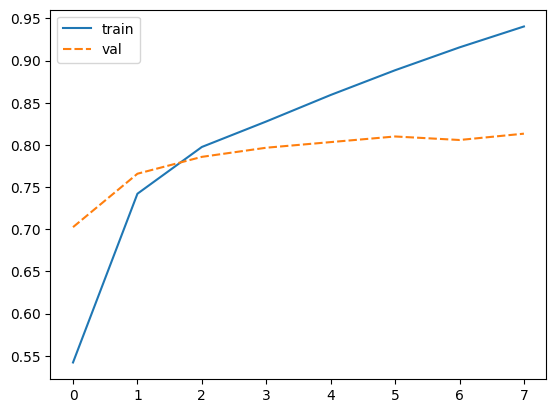

In [ ]:
# Plot the learning curve
curve = pd.DataFrame({"train": history.history["accuracy"], "val": history.history["val_accuracy"]})
plot = sns.lineplot(data=curve)

In [ ]:
# Evaluate on the test data
baseline.evaluate(test)

38/38 [==============================] - 0s 8ms/step - loss: 0.5525 - accuracy: 0.7758


[0.5524556040763855, 0.7758333086967468]

The accuracy of this model is significantly higher then random guessing. That being said it is not perfect and still has a fair amount of error. For a task like identifying facial expressions where even a human might mistake them sometimes this model does fairly well but certainly has room for improvement.

# Augmented model

Try adding image augmentation to your model.

(Consider which types of augmentation are likely to help.)

Comment on the performance of this model.

In [ ]:
# Design a network that augments the images
augmented = keras.models.Sequential([
    keras.Input(shape=(48, 48, 1)),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    keras.layers.Rescaling(1/255),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(3,activation ="softmax")
])

In [ ]:
# Train the network
stopping = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
augmented.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
history = augmented.fit(train, epochs=100, validation_data=val, callbacks=[stopping], verbose=False)

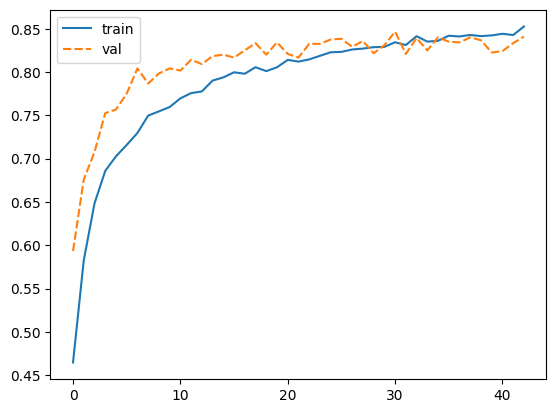

In [ ]:
# Plot the learning curve
curve = pd.DataFrame({"train": history.history["accuracy"], "val": history.history["val_accuracy"]})
plot = sns.lineplot(data=curve)

In [ ]:
# Evaluate on the test data
augmented.evaluate(test)

38/38 [==============================] - 0s 7ms/step - loss: 0.4468 - accuracy: 0.8175


[0.44680893421173096, 0.8174999952316284]

This model is even more accurate then the baseline and much higher then the random. This is a strong model for a task as complex as facial expression recognition. In addition this model has a lower loss then the baseline which indicates closer predicted and actual values which also indicates a stronger model then the baseline.




# Pretrained model

Try adapting a pretrained EfficientNetB0 to this task.

(You will run into a snag involving the input shape. Find a simple workaround!)

Comment on the performance of this model.




In [ ]:
# Load a pretrained convolutional base
base = keras.applications.EfficientNetB0(weights="imagenet", input_shape=(48, 48, 3), include_top=False)

In [ ]:
# Load in data on RGB scale to match pre-trained model
train_pre = keras.utils.image_dataset_from_directory("faces/train", image_size=(48, 48), color_mode="rgb", batch_size=32)
test_pre = keras.utils.image_dataset_from_directory("faces/test", image_size=(48, 48), color_mode="rgb", batch_size=32)
val_pre = keras.utils.image_dataset_from_directory("faces/val", image_size=(48, 48), color_mode="rgb", batch_size=32)

Found 9000 files belonging to 3 classes.
Found 1200 files belonging to 3 classes.
Found 1200 files belonging to 3 classes.


In [ ]:
# Freeze the pretrained weights
base.trainable = False

In [ ]:
# Design a network around the pretrained base
pretrained = keras.models.Sequential([
    keras.Input(shape=(48, 48, 3)),
    keras.layers.Lambda(keras.applications.efficientnet.preprocess_input),
    base,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(3,activation ="softmax")
])

In [ ]:
# Train the network
stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
pretrained.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
history = pretrained.fit(train_pre, epochs=100, validation_data=val_pre, callbacks=[stopping], verbose=False)

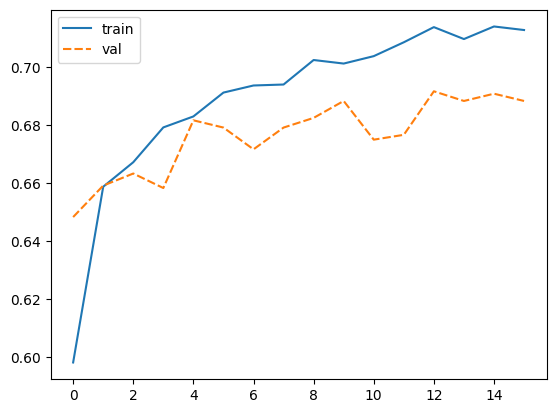

In [ ]:
# Plot the learning curve
curve = pd.DataFrame({"train": history.history["accuracy"], "val": history.history["val_accuracy"]})
plot = sns.lineplot(data=curve)

In [ ]:
# Evaluate on the test data
pretrained.evaluate(test_pre)

38/38 [==============================] - 1s 19ms/step - loss: 0.6902 - accuracy: 0.7008


[0.6902365684509277, 0.7008333206176758]

This model performs worse then the baseline and augmented models both in terms of loss and accuracy. This is most likely due to the use of color images in the pretraining compared to the black and white photos in our data set as well as what the data was trained on. With that in mind ~70% accuracy is not terrible but is the worst model we have evaluated and is lower then expected for pre-trained model implementation (without considering which pre-train model we use).

# Reflections

Think, read, and discuss to inform your answers to these questions:
- What are some possible explanations for the performance of the pretrained model on this task?

The pretrained model uses RGB images in its pretraining and then reads in the greyscale image data as color to conform to the model. This difference between colored and greyscale images could be a factor in this models performance. Also imagenet is a general pretraining that includes images of various other non-face things that arent in our model. This could allow our pretraining to help in some aspects such as distinguishing a face from not a face but not distiguish between actual facial expressions. From this same idea of a larger image type training, there might also be fewer number of face images to train with in the pre-training phase and a greater number of random objects that do not help in this task.

- What are some possible ideas for building a better face classifier than we have so far?
Find a pretrained model that is on faces (preferably greyscale images) and then further train the model using augmentation techniques to tune the model even more. This could combine beneficial aspects of both models with pretraining to allow for better classification and feature identification of facial aspects and then augmentation which introduces noise to the training data in the hopes of allowing the model to better classify varying images. This gives the model more variaty of data to train on and can allow the model to preform better on the true data it was not trained on. Combining these two models strategies could have many benefits for improving our model. We could also try fine-training with more layers (deeper).


- What are some possible ethical concerns involved in building face classifiers?

Building face classifiers has many ethical risks. While our model classifies expressions this same models and ideas could be used to identify and target certain groups such as gender or race which has many unethical implications and potential for serious discrimination. On a more individual scale this could be used to identify individuals faces which is a major violation of privacy and could be used to ID and target people.